# The necessary text files that needed to be parsed to run this code could not be pushed to GitHub due to their size, if you want to run this code, please download them and name the files accordingly

In [54]:
import goatools
from goatools import obo_parser
from goatools.obo_parser import OBOReader
from goatools.obo_parser import GOTerm
from goatools.obo_parser import GODag
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#This section of code was taken from StackOverflow to solve the problem of version 2.2 files not being able to be parsed by 
#Bio.UniProt.GOA

GAF22FIELDS = [
    "DB",
    "DB_Object_ID",
    "DB_Object_Symbol",
    "Qualifier",
    "GO_ID",
    "DB:Reference",
    "Evidence_Code",
    "With",
    "Aspect",
    "DB_Object_Name",
    "DB_Object_Synonym",
    "DB_Object_Type",
    "Taxon",
    "Date",
    "Assigned_By",
    "Annotation_Extension",
    "Gene_Product_Form_ID",
]

def gaf22iterator(handle):
    for inline in handle:
        if inline[0] == "!":
            continue
        inrec = inline.rstrip("\n").split("\t")
        if len(inrec) == 1:
            continue
        inrec[3] = inrec[3].split("|")  # Qualifier
        inrec[5] = inrec[5].split("|")  # DB:reference(s)
        inrec[7] = inrec[7].split("|")  # With || From
        inrec[10] = inrec[10].split("|")  # Synonym
        inrec[12] = inrec[12].split("|")  # Taxon
        yield dict(zip(GAF22FIELDS, inrec))

In [3]:
go_dag = GODag(optional_attrs='relationship_set')

go-basic.obo: fmt(1.2) rel(2022-10-07) 46,825 Terms


In [4]:
humanfile = 'goa_human.gaf'
human_annotations = {}
for entry in gaf22iterator(open(humanfile)):
    uniprot_id = entry.pop('GO_ID')
    human_annotations[uniprot_id] = entry

In [5]:
humterm = human_annotations[list(human_annotations.keys())[7]]
print(humterm)

{'DB': 'UniProtKB', 'DB_Object_ID': 'P07766', 'DB_Object_Symbol': 'CD3E', 'Qualifier': ['part_of'], 'DB:Reference': ['PMID:21873635'], 'Evidence_Code': 'IBA', 'With': ['PANTHER:PTN000060280', 'UniProtKB:P09693', 'MGI:MGI:88333', 'MGI:MGI:88331', 'MGI:MGI:88332', 'UniProtKB:P07766', 'UniProtKB:P04234'], 'Aspect': 'C', 'DB_Object_Name': 'T-cell surface glycoprotein CD3 epsilon chain', 'DB_Object_Synonym': ['CD3E', 'T3E'], 'DB_Object_Type': 'protein', 'Taxon': ['taxon:9606'], 'Date': '20210529', 'Assigned_By': 'GO_Central', 'Annotation_Extension': '', 'Gene_Product_Form_ID': ''}


In [6]:
go_dag_anscestors = {}
for goterm in go_dag:
    parents = go_dag[goterm].get_all_parents()
    anscestorgraph = nx.DiGraph()
    for parent in parents:
        anscestorgraph.add_edge(goterm, parent)
    go_dag_anscestors[goterm] = anscestorgraph   

In [7]:
human_annotations_transferred = dict()
for gene in human_annotations.keys():
    try:
        gograph = go_dag_anscestors[gene].nodes()
        graph = nx.DiGraph()
        for node in gograph:
            if node in human_annotations.keys():
                graph.add_edge(gene, node)
        human_annotations_transferred[gene] = graph
    except:
        print('fail')

In [9]:
nbp = 0
for gene in human_annotations.keys():
    try:
        name = go_dag[gene].namespace
        if(name == 'biological_process'):
            nbp+=1
    except:
        print('fail')
print(nbp)

12550


In [10]:
nmf = 0
for gene in human_annotations.keys():
    try:
        name = go_dag[gene].namespace
        if(name == 'molecular_function'):
            nmf+=1
    except:
        print('fail')
print(nmf)

4552


In [11]:
ncc = 0
for gene in human_annotations.keys():
    try:
        name = go_dag[gene].namespace
        if(name == 'cellular_component'):
            ncc+=1
    except:
        print('fail')
print(ncc)

1790


In [12]:
bpterms10 = []
bpterms1 = []
for gene in human_annotations.keys():
    try:
        children = go_dag[gene].get_all_children()
        bpcounter = 0
        for child in children:
            if child in human_annotations.keys():
                if go_dag[child].namespace == 'biological_process':
                    bpcounter +=1
        if bpcounter > nbp/10:
            bpterms10.append(gene)
            
        if bpcounter > nbp/100:
            bpterms1.append(gene)
    except:
        print('fail')

In [13]:
mfterms10 = []
mfterms1 = []
for gene in human_annotations.keys():
    try:
        children = go_dag[gene].get_all_children()
        mfcounter = 0
        for child in children:
            if child in human_annotations.keys():
                if go_dag[child].namespace == 'molecular_function':
                    mfcounter +=1
        if mfcounter > nmf/10:
            mfterms10.append(gene)
            
        if mfcounter > nmf/100:
            mfterms1.append(gene)
    except:
        print('fail')

In [14]:
ccterms10 = []
ccterms1 = []
for gene in human_annotations.keys():
    try:
        children = go_dag[gene].get_all_children()
        cccounter = 0
        for child in children:
            if child in human_annotations.keys():
                if go_dag[child].namespace == 'cellular_component':
                    cccounter +=1
        if cccounter > ncc/10:
            ccterms10.append(gene)
            
        if cccounter > ncc/100:
            ccterms1.append(gene)
    except:
        print('fail')

In [15]:
sbp1 = []
for term in bpterms1:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in bpterms1:
            inlist = True
    if not inlist:
        sbp1.append(term)
sbp10 = []
for term in bpterms10:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in bpterms10:
            inlist = True
    if not inlist:
        sbp10.append(term)

In [16]:
smf1 = []
for term in mfterms1:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in mfterms1:
            inlist = True
    if not inlist:
        smf1.append(term)
smf10 = []
for term in mfterms10:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in mfterms10:
            inlist = True
    if not inlist:
        smf10.append(term)

In [17]:
scc1 = []
for term in ccterms1:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in ccterms1:
            inlist = True
    if not inlist:
        scc1.append(term)
scc10 = []
for term in ccterms10:
    inlist = False
    for parent in go_dag[term].get_all_parents():
        if parent in ccterms10:
            inlist = True
    if not inlist:
        scc10.append(term)

In [70]:
def classifier(terms: list):
    codes = dict()
    codes['EXP'] = 0
    codes['HTP'] = 0
    codes['PHYLO'] = 0
    codes['COMP'] = 0
    codes['AUTH'] = 0
    codes['IEA'] = 0
    codes['ND'] = 0
    for term in terms:
        ec = human_annotations[term]['Evidence_Code']
        if ec in ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']:
            codes['EXP']+=1
        elif ec in ['HTP', 'HDA', 'HMP', 'HGI', 'HEP']:
            codes['HTP']+=1
        elif ec in ['IBA', 'IBD', 'IKR', 'IRD']:
            codes['PHYLO']+=1
        elif ec in ['ISS', 'ISO', 'ISA', 'ISM', 'IGC', 'RCA']:
            codes['COMP']+=1
        elif ec in ['TAS', 'NAS', 'IC']:
            codes['AUTH']+=1
        elif ec == 'IEA':
            codes['IEA']+=1
        else:
            codes['ND']+=1
    return codes

In [71]:
bp1 = classifier(bpterms1)
mf1 = classifier(mfterms1)
cc1 = classifier(ccterms1)
bp10 = classifier(bpterms10)
mf10 = classifier(mfterms10)
cc10 = classifier(ccterms10)

In [92]:
labels = ['Biological Process', 'Molecular Function', 'Cellular Component']
b1 = bp1['EXP']
m1 = mf1['EXP']
c1 = cc1['EXP']
exp = np.array([b1, m1, c1])
htp = [bp1['HTP'], mf1['HTP'], cc1['HTP']]
phylo = [bp1['PHYLO'], mf1['PHYLO'], cc1['PHYLO']]
comp = [bp1['COMP'], mf1['COMP'], cc1['COMP']]
auth = [bp1['AUTH'], mf1['AUTH'], cc1['AUTH']]
iea = [bp1['IEA'], mf1['IEA'], cc1['IEA']]
nd = [bp1['ND'], mf1['ND'], cc1['ND']]

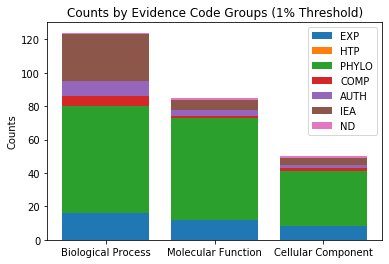

In [95]:
plt.bar(labels, exp, label='EXP')
plt.bar(labels, htp, bottom=exp, label='HTP')
plt.bar(labels, phylo, bottom=exp + htp, label='PHYLO')
plt.bar(labels, comp, bottom=exp + htp + phylo, label='COMP')
plt.bar(labels, auth, bottom=exp + htp + phylo + comp, label='AUTH')
plt.bar(labels, iea, bottom=exp + htp + phylo + comp + auth, label='IEA')
plt.bar(labels, nd, bottom=exp + htp + phylo + comp + auth + iea, label='ND')

plt.ylabel('Counts')
plt.title('Counts by Evidence Code Groups (1% Threshold)')
plt.legend(['EXP', 'HTP', 'PHYLO', 'COMP', 'AUTH', 'IEA', 'ND'])
plt.show()

In [96]:
b10 = bp10['EXP']
m10 = mf10['EXP']
c10 = cc10['EXP']
exp = np.array([b10, m10, c10])
htp = [bp10['HTP'], mf10['HTP'], cc10['HTP']]
phylo = [bp10['PHYLO'], mf10['PHYLO'], cc10['PHYLO']]
comp = [bp10['COMP'], mf10['COMP'], cc10['COMP']]
auth = [bp10['AUTH'], mf10['AUTH'], cc10['AUTH']]
iea = [bp10['IEA'], mf10['IEA'], cc10['IEA']]
nd = [bp10['ND'], mf10['ND'], cc10['ND']]

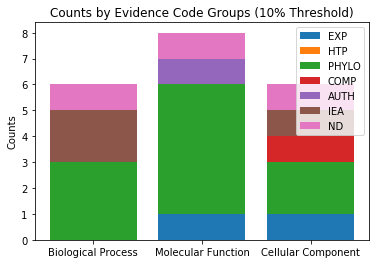

In [98]:
plt.bar(labels, exp, label='EXP')
plt.bar(labels, htp, bottom=exp, label='HTP')
plt.bar(labels, phylo, bottom=exp + htp, label='PHYLO')
plt.bar(labels, comp, bottom=exp + htp + phylo, label='COMP')
plt.bar(labels, auth, bottom=exp + htp + phylo + comp, label='AUTH')
plt.bar(labels, iea, bottom=exp + htp + phylo + comp + auth, label='IEA')
plt.bar(labels, nd, bottom=exp + htp + phylo + comp + auth + iea, label='ND')

plt.ylabel('Counts')
plt.title('Counts by Evidence Code Groups (10% Threshold)')
plt.legend(['EXP', 'HTP', 'PHYLO', 'COMP', 'AUTH', 'IEA', 'ND'])
plt.show()